# Visual Feature for Image Retrieval


In [1]:
import numpy as np
import cv2
import glob
import os
from PIL import Image
import matplotlib.pyplot as plt

from IPython.display import HTML, display

In [2]:
# parameters
NUM_OF_CATEGORY = 35
NUM_OF_RELEVANT = 20

# categories
categories = [c.split('/')[1] for c in glob.glob('data/*')]
categories.sort()

def getCategory(index):
    return categories[index // NUM_OF_RELEVANT]

def getFilename(index):
    category = getCategory(index)
    return category, os.path.join('data', category, category + '_' + str(index % NUM_OF_RELEVANT + 1) + '.jpg')

## Feature Extraction
### Color Similarity
- Grid color moments: 
    
    Slice image into 5x5 grids, and compute 1st, 2nd, and 3rd moments for each grid in each color channel (RGB color space). 
    <br> The feature is flatten as 225 dimension.

### Texture/Shape Similarity
- Gabor texture

    Reference:
    - https://www.itread01.com/content/1546890854.html
    

### Local Feature Similarity
- VLAD

In [3]:
# Feature extraction
def feature_extraction(name, method, path='features/', overwrite=False, **kwargs):
    
    # load from files
    filepath = os.path.join(path, name + '.npy')
    if not overwrite and os.path.isfile(filepath):
        print('load from file')
        return np.load(filepath, allow_pickle=True)
    
    features = []
    for category in categories:
        for i in range(1, 21):

            # read image
            filename = os.path.join('data', category, category + '_' + str(i) + '.jpg')
            # print(filename)
            img = cv2.imread(filename)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # extract feature
            feature = method(img, **kwargs)

            # store feature
            features.append(feature)
            
    # save features into file
    features = np.array(features)
    np.save(filepath, features)
    
    return features
    

In [4]:
# Color similarity
def grid_color_moment(img, gx=5, gy=5):
    # parametrs
    height, width, _ = img.shape

    # grid color moment
    gcm = []
    for i in range(gx):
        for j in range(gy):
            for k in range(3):
                grid = img[i*height//gx:(i+1)*height//gx, j*width//gy:(j+1)*width//gy, k]

                m1 = np.mean(grid)
                m2 = np.std(grid)
                m3 = np.mean((grid-m1)**3)
                m3 = np.sign(m3) * np.power(np.abs(m3), 1/3)

                gcm.append(m1)
                gcm.append(m2)
                gcm.append(m3)
                
    return gcm

In [5]:
# Texture/shape similarity
def gabor_texture(img, gx=1, gy=1, K=6, S=4, ksize=31, sigma=4, gamma=0.5):
    # Gabor filters
    filters = genGaborFilters()
    # Convolution
    
    
    # Feature vector

def genGaborFilters(ksize=127, K=6, S=4, U_h=0.4, U_l=0.05):

    a = (U_h/U_l)**(1/(S-1))
    # print(a)
    
    # gamma = sigma_x / sigma_y = sigma_v / sigma_u
    sigma_u = ((a-1)*U_h)/((a+1)*np.sqrt(2*np.log(2)))
    #sigma_v = np.tan(np.pi/(2*K))*(U_h-2*np.log(sigma_u**2/U_h))*(2*np.log(2)-((2*np.log(2)*sigma_u)/U_h)**2)**(-1/2)
    sigma_v = np.tan(np.pi/(2*K))*np.sqrt(U_h**2/(2*np.log(2))-sigma_u**2)
    gamma = sigma_v / sigma_u
    
    sigma_base = 1/(2*np.pi*sigma_u)
    # wavelength = 1/freq ?
    lambd_base = 1/U_h
    # print(sigma_u, sigma_v, sigma_base)
    
    filters = []
    
    for m in range(S):
        lambd = lambd_base / a**(-m)
        sigma = sigma_base / a**(-m)
        # print(lambd, sigma, gamma)
        
        for n in range(K):
            theta = n * np.pi / K

            kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, 0, cv2.CV_32F)
            filters.append(kernel)
    
    return filters

# def customGabor(ksize, sigma_x, sigma_y, W):
    
#     sigma_u = 1/(2*np.pi*sigma_x)
#     sigma_v = 1/(2*np.pi*sigma_y)
#     G = []
#     for u in range(-ksize//2, ksize//2):
#         G_r = []
#         for v in range(-ksize//2, ksize//2):
#             G_r.append(np.exp(-1/2*(((u-W)/sigma_u)**2 + (v/sigma_v)**2)))
#         G.append(G_r)
    
#     #(1/2*np.pi*sigma_x*sigma_y)*np.exp(-1/2*())
#     return np.array(G)
    


In [6]:
# Local feature similarity

In [7]:
# Extract features
feature_gcm = feature_extraction('grid_color_moment', grid_color_moment, overwrite=False)
print(feature_gcm.shape)

load from file
(700, 225)


In [8]:
# G = customGabor(31, 0.4, 0.4, 10)
# print(np.shape(G))
# print(G[17, 16])
# print(np.max(G), np.min(G))
# plt.imshow(G, 'gray')
# plt.show()

# plt.imshow(np.fft.ifftshift(np.fft.ifft(G)).real, 'gray')
# plt.show()

## Evaluations

In [9]:
# Ranking
def ranking(features):
    # row: target, col: compare
    target = np.reshape(features, (features.shape[0], 1, features.shape[1]))
    compare = features
    
    # distance/similarity
    dif = target - compare
    dist = np.linalg.norm(dif, ord=2, axis=2)
    
    # ranking
    ranked = np.argsort(dist, axis=1)
    
    return ranked, dist
    

In [10]:
def computeMAP(ranking):
    
    MAP = []
    
    for rank in ranking:
        
        tp = 0 # true positive
        fp = 0 # false positive 

        precision = []
        #recall = []
        AP = []
        
        for i in range(1, len(rank)):
            if rank[0] // NUM_OF_RELEVANT == rank[i] // NUM_OF_RELEVANT:
                tp += 1
                precision.append(tp / (tp + fp))
                #recall.append(tp / NUM_OF_RELEVANT)
                AP.append(precision[-1])
            else:
                fp += 1
                precision.append(tp / (tp + fp))
                #recall.append(tp / NUM_OF_RELEVANT)
                
#         print('---')
#         print(AP)
        AP = np.mean(AP)
        MAP.append(AP)
    
#     print('===')
#     print(MAP)
    MMAP = np.mean(MAP)
    MAP = [np.mean(MAP[i*NUM_OF_RELEVANT:(i+1)*NUM_OF_RELEVANT]) for i in range(NUM_OF_CATEGORY)]
    return MMAP, MAP
                
            

In [11]:
# Evaluations
results = {}

In [12]:
# Grid Color Moment
ranked, _ = ranking(feature_gcm)

# MAP
MMAP, MAP = computeMAP(ranked)
print(MMAP)
print(MAP)

results['grid_color_moment'] = {
    'MMAP': MMAP,
    'MAP': MAP
}

0.16312383439389377
[0.22268839489617634, 0.20438041647988134, 0.10543679602837197, 0.2165387909808544, 0.08007585969761741, 0.13471623936624627, 0.08669789077240972, 0.13048108405110875, 0.1633886546629208, 0.15377130942830688, 0.1914857804958567, 0.13046755268794, 0.41530688106014796, 0.29656326643935976, 0.07393853035386445, 0.4335887170008209, 0.1385580147573764, 0.0792110009347464, 0.08535934521819034, 0.25443250107852705, 0.26164258055510214, 0.14609450746820798, 0.1541130017991042, 0.06881901835697084, 0.06910719922795201, 0.03910402905791407, 0.16509402464819503, 0.15909493911280956, 0.11874316787285052, 0.24013865498050482, 0.1374719235195142, 0.035648943730957276, 0.15358202303331925, 0.15414953427242378, 0.2094436297597332]


In [13]:
# Comparison between methods
table = """
<table>
<tr>
<th>categories vs. methods</th>
<th>MAP</th>
<th>Best Two Categories (w/ MAP)</th>
<th>Worst Two Categories (w/ MAP)</th>
</tr>
"""
for key in results:
    MAP = results[key]['MAP']
    MAP_sort = np.argsort(MAP)
    # print(MAP_sort)
    
    table += """
    <tr>
    <td>{}</td>
    <td>{:.3f}</td>
    <td>{} ({:.3f}), {} ({:.3f})</td>
    <td>{} ({:.3f}), {} ({:.3f})</td>
    </tr>
    """.format(key, results[key]['MMAP'], categories[MAP_sort[-1]], MAP[MAP_sort[-1]], categories[MAP_sort[-2]], MAP[MAP_sort[-2]], categories[MAP_sort[0]], MAP[MAP_sort[0]], categories[MAP_sort[1]], MAP[MAP_sort[1]])
    
table += "</table>"
display(HTML(table))

categories vs. methods,MAP,Best Two Categories (w/ MAP),Worst Two Categories (w/ MAP)
grid_color_moment,0.163,"goggles (0.434), garment (0.415)","sweeping_robot (0.036), nba_jersey (0.039)"


Target Image: data/trousers/trousers_1.jpg


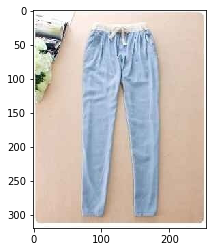

Result Images 1: data/aloe_vera_gel/aloe_vera_gel_2.jpg


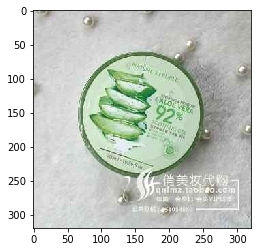

Result Images 2: data/trousers/trousers_8.jpg


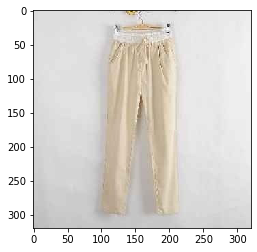

Result Images 3: data/trousers/trousers_18.jpg


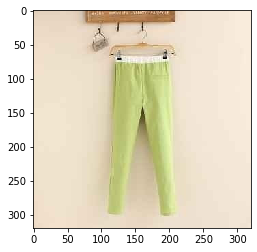

Result Images 4: data/mouse/mouse_12.jpg


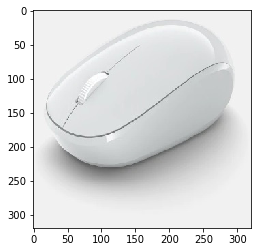

Result Images 5: data/leather_purse/leather_purse_7.jpg


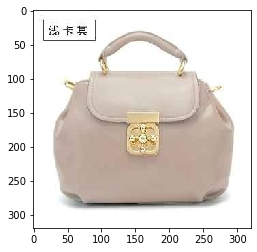

Result Images 6: data/trousers/trousers_7.jpg


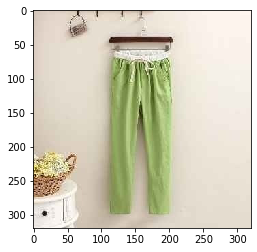

Result Images 7: data/clock/clock_7.jpg


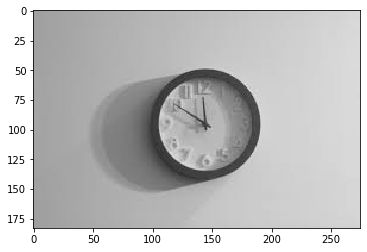

Result Images 8: data/ice_cream/ice_cream_18.jpg


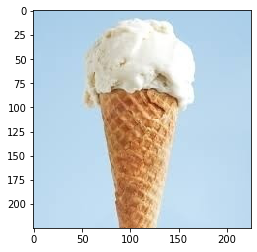

Result Images 9: data/garment/garment_20.jpg


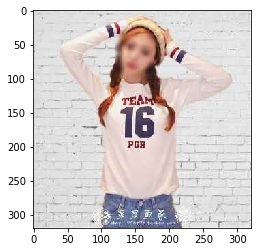

Result Images 10: data/ice_cream/ice_cream_20.jpg


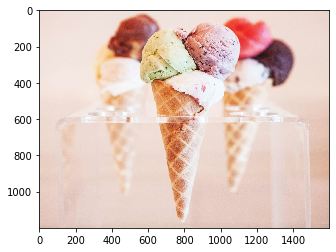

Result Images 11: data/trousers/trousers_19.jpg


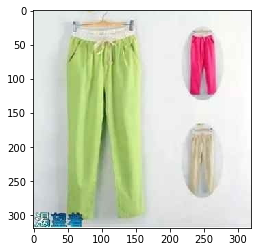

Result Images 12: data/aloe_vera_gel/aloe_vera_gel_4.jpg


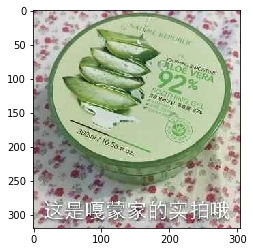

Result Images 13: data/baby_shoes/baby_shoes_17.jpg


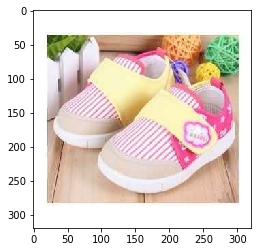

Result Images 14: data/aloe_vera_gel/aloe_vera_gel_12.jpg


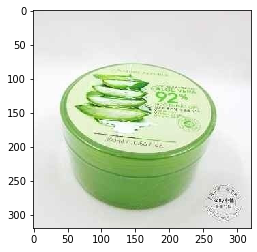

Result Images 15: data/trousers/trousers_16.jpg


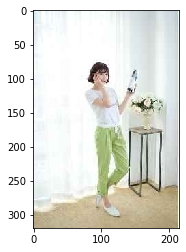

Result Images 16: data/goggles/goggles_9.jpg


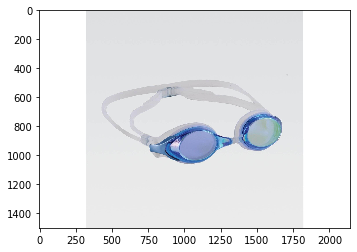

Result Images 17: data/glasses/glasses_15.jpg


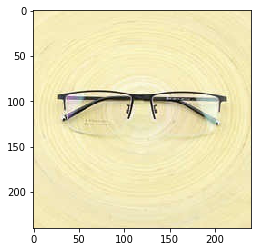

Result Images 18: data/lollipop/lollipop_18.jpg


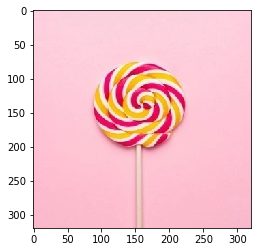

Result Images 19: data/trousers/trousers_10.jpg


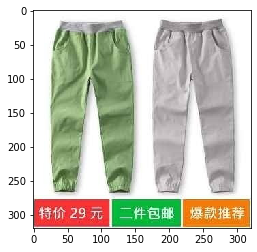

In [14]:
# Visualization
# target image
target_idx = 33*20
cat, filename = getFilename(target_idx)
print('Target Image:', filename)
plt.imshow(Image.open(filename))
plt.show()

# queried images
for i in range(1, 20):
    result_idx = ranked[target_idx, i]
    cat, filename = getFilename(result_idx)
    print('Result Images {}: {}'.format(i, filename))
    plt.imshow(Image.open(filename))
    plt.show()

# Visualization


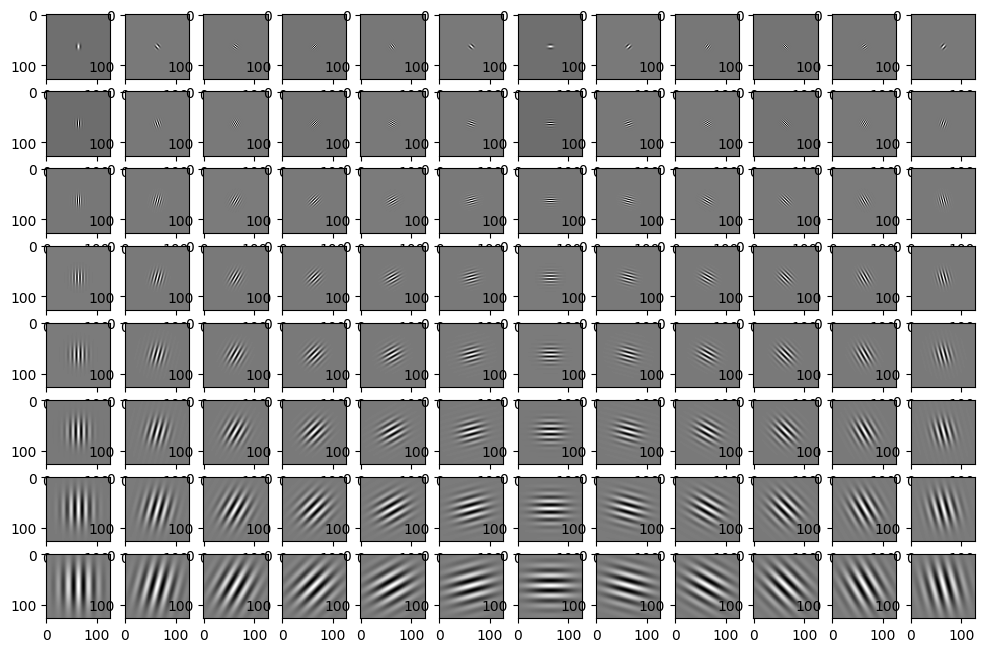

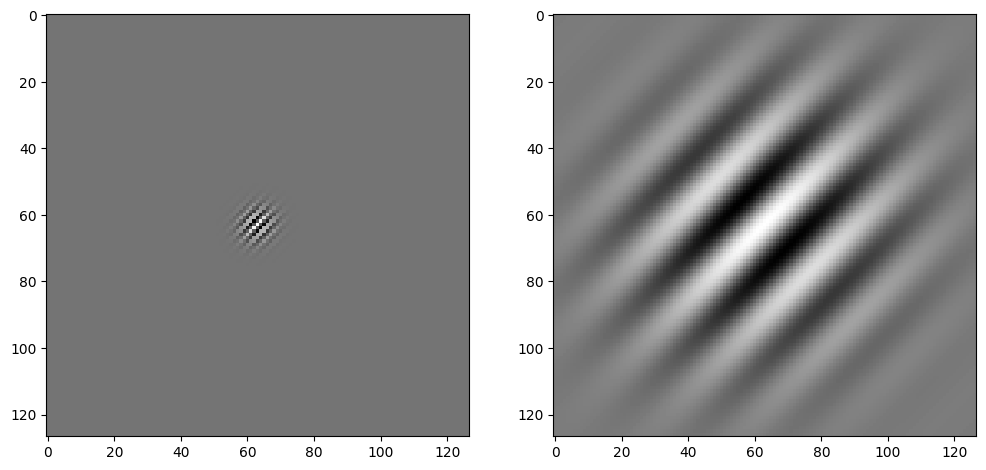

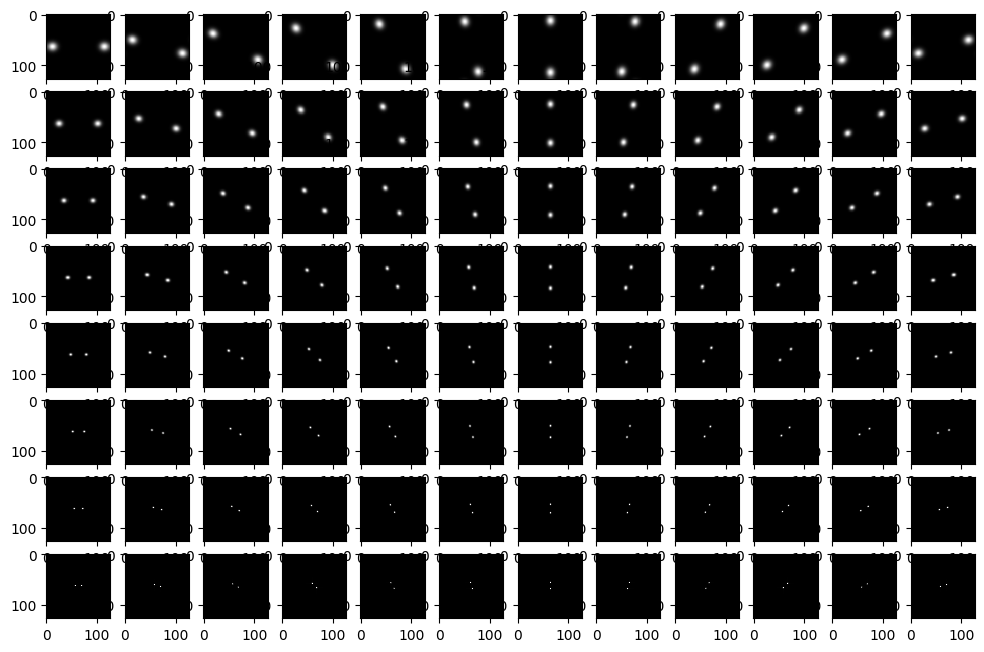

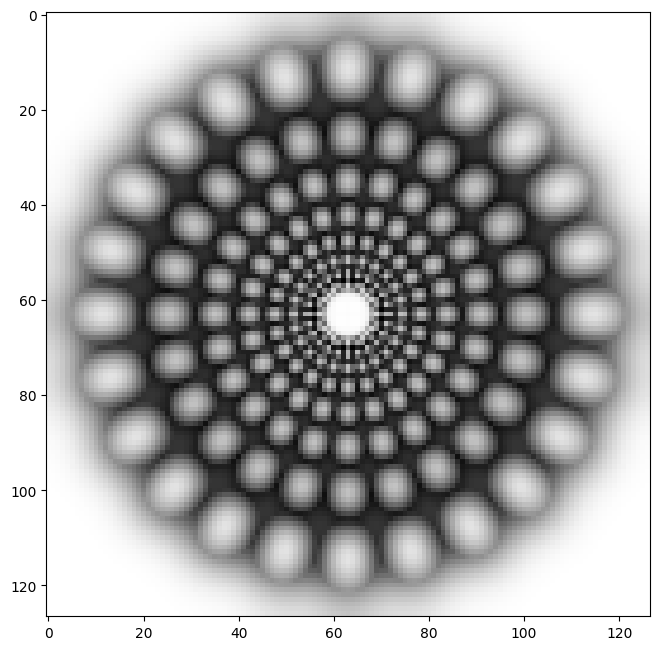

In [15]:
# Gabor filter
# figure size
org_fz = plt.rcParams['figure.figsize']
org_dpi = plt.rcParams['figure.dpi']
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# generate filters
K = 12
S = 8
filters = genGaborFilters(K=K, S=S)

# display filters
for i in range(S*K):
    plt.subplot(S, K, i+1)
    plt.imshow(filters[i], 'gray')
plt.show()

# display filters with certain orientation
orientation = 3
plt.subplot(1, 2, 1)
plt.imshow(filters[orientation], 'gray')
plt.subplot(1, 2, 2)
plt.imshow(filters[K*(S-1)+orientation], 'gray')
plt.show()

# display Fourior transform of Gabor filter
half_peaks = None
for i in range(S*K):
    f = np.fft.fft2(filters[i])
    fshift = np.fft.fftshift(f)
    mag = np.abs(fshift)
    half_peak = np.abs(mag - np.max(mag)/2)
    if half_peaks is None:
        half_peaks = half_peak/np.max(mag)
    else:
        half_peaks += half_peak/np.max(mag)
    plt.subplot(S, K, i+1)
    plt.imshow(mag, 'gray')
plt.show()

# display half peak
plt.imshow(half_peaks, 'gray')
plt.show()

# reset figure size
plt.rcParams['figure.figsize'] = org_fz
plt.rcParams['figure.dpi'] = org_dpi